# Name  :  Reena Rajendra Prasad
# **Project Description: Twitter US Airline Sentiment**

Data Description:
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

[Git Hub Link to the Project ](https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-apr20-Reena-R/blob/master/Twitter_Sentiment_Analysis.ipynb)

In [249]:
#Import neccessary Libraries
import pandas as pd
import numpy as np
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re                   #regular expression

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.stem import WordNetLemmatizer             #Lemmatizer
from nltk.tokenize import word_tokenize             #word tokenizer
from bs4 import BeautifulSoup
import unicodedata
!pip install  contractions
import contractions

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer    

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [250]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [251]:
#Load  Dataset
df=pd.read_csv("/content/drive/My Drive/AIML/NLP Project/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [252]:
#sahpe of data
df.shape

(14640, 15)

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

**INSIGHTS**  : Data  Contains  14640   rows of non null tweets  and airline_sentiment   Which are the relevent columns here for analysis

In [254]:
# describe the Data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


In [255]:
#ColumnNames
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [256]:
# Delete unnecessary columns
df_data = df.drop(['tweet_id','airline_sentiment_confidence','negativereason', 'negativereason_confidence', 'airline','airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created','tweet_location', 'user_timezone'],axis=1)

In [257]:
#Shape Of Data
df_data.shape

(14640, 2)

In [258]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [259]:
#Set max column width 
pd.set_option('display.max_colwidth', None)
df_data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [260]:
df_data['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

**Insight** :  The data is higly unbalanced  , with more number of negative   feed backs 


**Text pre-processing**

# a. Html tag removal.

In [261]:
def strip_html(txt):
    soup=BeautifulSoup(txt,'html.parser')
    return soup.get_text()

In [262]:
for i, row in df_data.iterrows():
   text = df_data.at[i, 'text']
   new_txt = strip_html(text)
   df_data.at[i,'text'] = new_txt

In [263]:
df_data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


# Remove UrlS

In [264]:
def remove_url(txt):
   pattern= r'http\S+'
   return re.sub(pattern,'',txt)  

In [265]:
for i, row in df_data.iterrows():
   text = df_data.at[i, 'text']
   new_txt = remove_url(text)
   df_data.at[i,'text'] = new_txt

In [266]:
df_data.head(20)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there."
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


# Remove contractions 

In [267]:
# Remove contractions 
def replace_contractions(text):   
    return contractions.fix(text)

In [268]:
for i, row in df_data.iterrows():
   text = df_data.at[i, 'text']
   new_txt = replace_contractions(text)
   df_data.at[i,'text'] = new_txt

In [269]:
df_data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


# b. Tokenization.


In [270]:
def tokenize_txt(txt):
    words = nltk.word_tokenize(text)
    return words

In [271]:
for i, row in df_data.iterrows():
   text = df_data.at[i, 'text']
   new_txt = tokenize_txt(text)
   df_data.at[i,'text'] = new_txt

In [272]:
df_data.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


# c. Function to Remove the numbers.

In [273]:
def remove_numbers(txt):
  pattern= r'[0-9]'
  new_words=[]
  for word in txt:
    new_words.append(re.sub(pattern,'',word))
  return new_words


# d. Removal of Special Characters and Punctuations.

In [274]:
#function to Convert to  Ascii 
def convert_Ascii(txt):
  new_words = []
  for word in txt:
      new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
      new_words.append(new_word)
  return new_words

  

In [275]:
# Function to   Remove punctuation  
def remove_punctuation(txt):
  pattern= r'[^\w\s]'
  new_words=[]
  for word in txt:
    new_word = re.sub(pattern,'', word)
    if new_word != '':
      new_words.append(new_word) 
  return new_words
  

In [276]:
# Function to   Remove Special characters 
def remove_specialchars(txt):
  pattern= r'[^a-zA-Z\s]'
  new_words=[]
  for word in txt:
    new_words.append(re.sub(pattern,'',word))
  return new_words

# e. Conversion to lowercase.

In [277]:
# Function to  convert to lower
def convert_lower(txt):
  new_words=[]
  for word in txt:
    new_words.append(word.lower())
  return new_words

# Function to remove stopwords

In [278]:
stopw = stopwords.words('english')

customlist = ['no','not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Custom stopwordlist  so that it will not remove the negative sentimet words

stopw = list(set(stopw) - set(customlist))                           

In [279]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopw:
            new_words.append(word)
    return new_words


# f. Lemmatization

In [280]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

# g. Join the words in the list to convert back to text string in the dataframe

Define Function to Apply all the preprocessing Steps 

In [281]:
def normalize(words):
    words = remove_numbers(words)
    words = convert_lower(words)
    words = convert_Ascii(words)
    words = remove_punctuation(words)
    words= remove_specialchars(words)
    words = remove_stopwords(words)
    words = lemmatize_words(words)
    return ' '.join(words)

In [282]:
df_data['text'] = df_data.apply(lambda row: normalize(row['text']), axis=1)


# h. Print first 5 rows of data after pre-processing.

In [283]:
df_data.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


In [284]:
#Replace Y String variable with integre values   
replaceStruct={"airline_sentiment":{"neutral":1,"positive":2,"negative":0}
              }

df_data=df_data.replace(replaceStruct)

In [285]:
df_data.head()

,airline_sentiment,text
0,1,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience tacky
2,1,virginamerica not today must mean need take another trip
3,0,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,0,virginamerica really big bad thing


In [286]:
df_data.dtypes

airline_sentiment     int64
text                 object
dtype: object

# Vectorization  : Count Vectorizer

In [287]:
vectorizer = CountVectorizer()               
data_CountV= vectorizer.fit_transform(df_data['text'])
data_CountV = data_CountV.toarray()     

In [288]:
data_CountV.shape

(14640, 10870)

In [289]:

print(", ".join([str(l) for l in data_CountV[900] if l !=0 ]))

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1


# Vectorization  : TFIDF Vectorizer

In [290]:
tfvectorizer = TfidfVectorizer()               
data_TfIdfV= tfvectorizer.fit_transform(df_data['text'])
data_TfIdfV = data_TfIdfV.toarray()     

In [291]:
data_TfIdfV.shape

(14640, 10870)

In [292]:
print(", ".join([str(l) for l in data_TfIdfV[900] if l !=0 ]))

0.40045351572527765, 0.14855119233552272, 0.09374619659169588, 0.15997708182432624, 0.19967543323983372, 0.19747318892108642, 0.27728355521454423, 0.38404991799337623, 0.38404991799337623, 0.35600778245190373, 0.22292108652739126, 0.09416092344120698, 0.19303692190467198, 0.3314858009204673


# Test Train Split For TFIDF   With Max Features Limited to 2000

In [293]:
tfvectorizer = TfidfVectorizer(max_features=2000)               
data_TfIdfV1000= tfvectorizer.fit_transform(df_data['text'])
data_TfIdfV1000 = data_TfIdfV1000.toarray()     

In [294]:
Y = df_data['airline_sentiment']
X =data_TfIdfV1000
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

In [295]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

forest = RandomForestClassifier(n_estimators=20, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, X_val, y_val, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7094624325446244


In [296]:
#testing score 
test_score =forest.score(X_test,y_test)
print("Accuracy >> ",test_score)

Accuracy >>  0.7668488160291439


In [297]:
y_pred = forest.predict(X_test)

In [298]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)
# Recall
print("Recall >> ",recall_score(y_test,y_pred,average='weighted'))
# Precision
print("Precision >> ",precision_score(y_test,y_pred,average='weighted'))
#F1 Score
print("F1 Score >> ",f1_score(y_test,y_pred,average='weighted'))

0.7668488160291439
Recall >>  0.7668488160291439
Precision >>  0.757766119870598
F1 Score >>  0.7497877587563472


In [299]:

#Recall and Precisicon for   each classes
cm = confusion_matrix(y_test, y_pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall,precision)


[0.94139466 0.45020747 0.54098361] [0.78527228 0.68238994 0.75572519]


# Confusion matrix

In [300]:
def draw_cm( actual, predicted ):
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1,2] , yticklabels = [0,1,2] ,cmap='Greens')
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

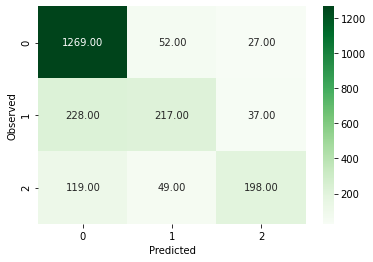

In [301]:
draw_cm(y_test,y_pred)

# Naive Bayes  on TFIDF Vectorized Data

In [302]:
from sklearn import naive_bayes
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)
predicted_prob = classifier.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
print(accuracy)

0.7358834244080146


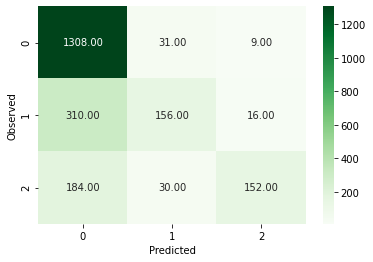

In [303]:
draw_cm(y_test,predicted)

In [304]:
accuracy = metrics.accuracy_score(y_test, predicted)
print(accuracy)
# Recall
print("Recall >> ",recall_score(y_test,predicted,average='weighted'))
# Precision
print("Precision >> ",precision_score(y_test,predicted,average='weighted'))
#F1 Score
print("F1 Score >> ",f1_score(y_test,predicted,average='weighted'))

0.7358834244080146
Recall >>  0.7358834244080146
Precision >>  0.7464806405484148
F1 Score >>  0.7010608438120485


In [305]:
#Recall and Precisicon for   each classes

cm = confusion_matrix(y_test, predicted)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall,precision)

[0.97032641 0.32365145 0.41530055] [0.72586016 0.71889401 0.85875706]


# Test Train Split For CountVectorizer With Max Features Limited to 2000

In [306]:
vectorizer = CountVectorizer(max_features=2000)               
data_CountV1000= vectorizer.fit_transform(df_data['text'])
data_CountV1000 = data_CountV1000.toarray()    

In [307]:
Y = df_data['airline_sentiment']
X =data_CountV1000
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

In [308]:

forest_Count = RandomForestClassifier(n_estimators=20, n_jobs=4)

forest_Count = forest.fit(X_train, y_train)

print(forest_Count)

print(np.mean(cross_val_score(forest_Count, X_val, y_val, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7117517642175176


In [309]:
#testing score 
test_score =forest_Count.score(X_test,y_test)
print(test_score)

0.76183970856102


In [310]:
y_pred = forest_Count.predict(X_test)

In [311]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)
# Recall
print("Recall >> ",recall_score(y_test,y_pred,average='weighted'))
# Precision
print("Precision >> ",precision_score(y_test,y_pred,average='weighted'))
#F1 Score
print("F1 Score >> ",f1_score(y_test,y_pred,average='weighted'))

0.76183970856102
Recall >>  0.76183970856102
Precision >>  0.7504354242033225
F1 Score >>  0.7521136999907324


In [312]:
#Recall and Precisicon for   each classes
cm = confusion_matrix(y_test, y_pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall,precision)

[0.90504451 0.48962656 0.59289617] [0.81009296 0.61139896 0.71381579]


# Confusion Matrix

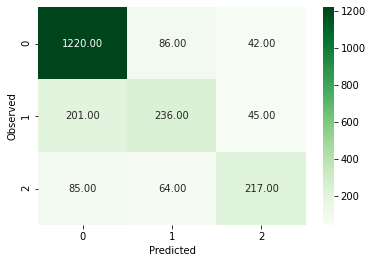

In [313]:
draw_cm(y_test,y_pred)

# Naive Bayes  on Count Vectorized Data

In [314]:
from sklearn import naive_bayes
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)
predicted_prob = classifier.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
print(accuracy)

0.7641165755919854


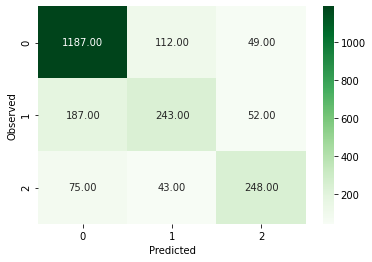

In [315]:
draw_cm(y_test,predicted)

In [316]:
accuracy = metrics.accuracy_score(y_test, predicted)
print(accuracy)
# Recall
print("Recall >> ",recall_score(y_test,predicted,average='weighted'))
# Precision
print("Precision >> ",precision_score(y_test,predicted,average='weighted'))
#F1 Score
print("F1 Score >> ",f1_score(y_test,predicted,average='weighted'))

0.7641165755919854
Recall >>  0.7641165755919854
Precision >>  0.755295496910124
F1 Score >>  0.7578457413458468


In [317]:
#Recall and Precisicon for   each classes

cm = confusion_matrix(y_test, predicted)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall,precision)

[0.8805638  0.50414938 0.67759563] [0.81918565 0.61055276 0.71060172]


# PCA to convert sparse matrix  into a datset  with reduced dimensionalty on TFIDF Vectorized Data

In [318]:
from sklearn.decomposition import PCA

In [319]:
# covMatrix = np.cov(data_TfIdfV,rowvar=False)
# print(covMatrix)

In [320]:
pca = PCA(n_components=2000)
pca.fit(data_TfIdfV)

PCA(copy=True, iterated_power='auto', n_components=2000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [321]:
print(pca.explained_variance_ratio_)

[1.26060735e-02 9.49428697e-03 8.64935335e-03 ... 6.90738518e-05
 6.89835931e-05 6.89675961e-05]


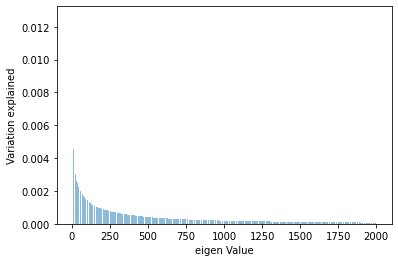

In [322]:
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.bar(list(range(1,2001)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

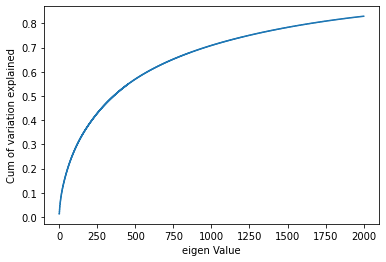

In [323]:
plt.step(list(range(1,2001)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [324]:
pcatfidf = PCA(n_components=1800)
pcatfidf.fit(data_TfIdfV)
print(pcatfidf.components_)
print(pcatfidf.explained_variance_ratio_)
pcatfidf = pcatfidf.transform(data_TfIdfV)

[[-6.06530722e-03 -1.31456499e-04 -1.08736305e-04 ... -2.39730043e-05
  -1.02207306e-04  2.66500475e-04]
 [ 2.20968968e-02  1.01753092e-04  1.20427613e-04 ... -9.78247040e-05
  -3.46589199e-04  8.04700897e-05]
 [ 1.04379592e-02 -7.87480321e-05 -6.99043494e-05 ... -1.55623970e-04
  -5.79035586e-04  1.59927436e-05]
 ...
 [-3.71395149e-03 -8.11104941e-04  2.80508039e-03 ... -6.99652974e-03
  -1.52854237e-02  2.65185162e-03]
 [ 3.77552994e-03 -7.75847465e-05  2.85199043e-03 ... -2.66764957e-03
  -1.42367105e-02  3.66203090e-03]
 [-8.24515167e-04  6.69545410e-03 -3.98436867e-04 ...  2.43932465e-02
   2.29968582e-02 -7.02712938e-04]]
[1.26060735e-02 9.49428697e-03 8.64935335e-03 ... 7.93619687e-05
 7.92021235e-05 7.91517968e-05]


# Train Test Split  PCA

In [325]:
Y = df_data['airline_sentiment']
X=pcatfidf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)


In [326]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

pcaforest = RandomForestClassifier(n_estimators=10, n_jobs=4)

pcaforest = pcaforest.fit(X_train, y_train)

print(pcaforest)

print(np.mean(cross_val_score(pcaforest, X_val, y_val, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6357036114570362


In [327]:
#testing score 
test_score =pcaforest.score(X_test,y_test)
print(test_score)

0.6666666666666666


# Summary of Preprocessing  techniques used
  Below are the pre processing techniques used here to clean up the unstructred  data in the text corpus to Structured data , which can be processed by the machine learning algorith.

*  Html tag removal :
> As the twitter data might be obtained using various web scaping methods . There are high chances that it contains various HTL elements  or HTML Tags . These tags does not add any vlaue to the model. So using te BeautifulSoup libraray  the HTML tags were removed .
*  Url removal :
> Urls will not add any value in this sentiment analysis context , so this has been removed using regular expressions 
*  Replace Contraction in the language with its expanded form:
> We have to replace contraction befor doing any special character replacement as  part of text preprocessing . This helps to retain the meaning of the sentence and in effect reduce the word frequecncies too.
*  Tokenization :
> Tokenization is used to convert the twitter feed back to a list of words , this is essential for getting the word frequencies when using count vectorizer or TFIDF   Vectorizer and Converting the document into machine redable numeric form  .
*  Remove the numbers.
>In this context the numbers in text does not  add value in the classification. so will remove the numbers using regular expression 

*  Removal of Special Characters and Punctuations.
>In the twitter sentiment analysis context  special characters such as  commas , hyphens does not add value , so these needs to be removed . here it is removed using the  regular expression 

*  Conversion to lowercase.
> In this context of sentiment analysis , we can convert the text into lowercase , this will reduce the  total unique number of words in the  documents  and frquency count will become more accurate  and this helps with dimensionality reduction
*  Stopword Removal
>  Stop words are the most commonly words ina texxt crpus , such as  "so , is, an ,a, on" . Removing these wors will not affect the basic meaning of the text  . The stopwords are downloaded here from the nltk  libraray and is customised so that the negative frequently used words such as no , not  etc  will not be removed from the text . As these negative words adds  value to the sentiment analysis context. Stopwords removal is used for  dimensionality reduction in vectorization.
*  Lemmatization
> Lemmatization of verbs are used and converted them into the basic form. This technique will redue the number of words in the preprocessed text  and lowers the dimensionality while retaining the meaning of the  text

# Models on  Count Vectorized Data
> Count Vectorization  : The  Document term matrix is created   using the countvectorzation method . This uses the count the number of times a each word  occurs in the document  . 

> Random Forest model and Naive bayse Model classifiers are tried out .  Accuracy of **Random forest** is **76.77** and  **Naive Bayes** is **76.41**

# Models on  Tf IDF Vectorized Data
> The Inverse document frequency vectorization captures the importance of words ina document . This type of vectorization reduces the impact of frequently used words in a document  . 

> Random Forest model and Naive bayse Model classifiers are tried out .  Accuracy of **Random forest** is **75.31** and  **Naive Bayes** is **73.58**

# PCA on  Tf IDF Vectorized Data
PCA  method is used to reduce the dimensionality of the TFIDF   vectorized data . PCA  final selection is done as 1800 based on the  variaence explained .
The random forest method on this data gives  only  accuracy of 66.93
